# Model Analysis & Feature Importance

In this notebook we perform feature importance analysis using **SHAP** and evalute the results of the models

In [1]:
import sys, os
sys.path.append(os.path.abspath(".."))
sys.path.append(os.path.abspath("../src"))
import mlflow.sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from xgboost import plot_importance
from collections import defaultdict
from sklearn.model_selection import train_test_split

from sklearn.metrics import (
    classification_report, roc_auc_score, average_precision_score,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, precision_recall_curve, confusion_matrix
)

from src.preprocessing import get_preprocessing_pipeline

## Data Prep

In [2]:
# Same data used during training
df = pd.read_csv("../data/bank_data.csv")
X = df.drop(columns=['target'])
y = df['target'].map({'no': 0, 'yes': 1})

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


## Load model with MLflow

In [4]:
# Change the path if needed
logreg_model = mlflow.sklearn.load_model("../src/mlruns/882110903822705047/3189aa8a66e24f189be58a93afdcadd6/artifacts/logreg_pipeline_model")
xgb_model = mlflow.sklearn.load_model("../src/mlruns/882110903822705047/e80a771915d04b14873e966eceaa2e37/artifacts/xgb_pipeline_model")

In [5]:
def evaluate_model(model, X_test, y_test, name=""):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    print(f"--- {name} ---")
    print(classification_report(y_test, y_pred))
    print("ROC AUC:", roc_auc_score(y_test, y_prob))
    print("AUC-PR:", average_precision_score(y_test, y_prob))
    print()

    return {
        "model": name,
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred),
        "roc_auc": roc_auc_score(y_test, y_prob),
        "auc_pr": average_precision_score(y_test, y_prob)
    }


--- Logistic Regression ---
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      7310
           1       0.69      0.22      0.33       928

    accuracy                           0.90      8238
   macro avg       0.80      0.60      0.64      8238
weighted avg       0.88      0.90      0.88      8238

ROC AUC: 0.8015402406953158
AUC-PR: 0.46484347675490717

--- XGBoost ---
              precision    recall  f1-score   support

           0       0.95      0.86      0.91      7310
           1       0.38      0.65      0.48       928

    accuracy                           0.84      8238
   macro avg       0.67      0.76      0.69      8238
weighted avg       0.89      0.84      0.86      8238

ROC AUC: 0.8136357404830417
AUC-PR: 0.47874469805418984



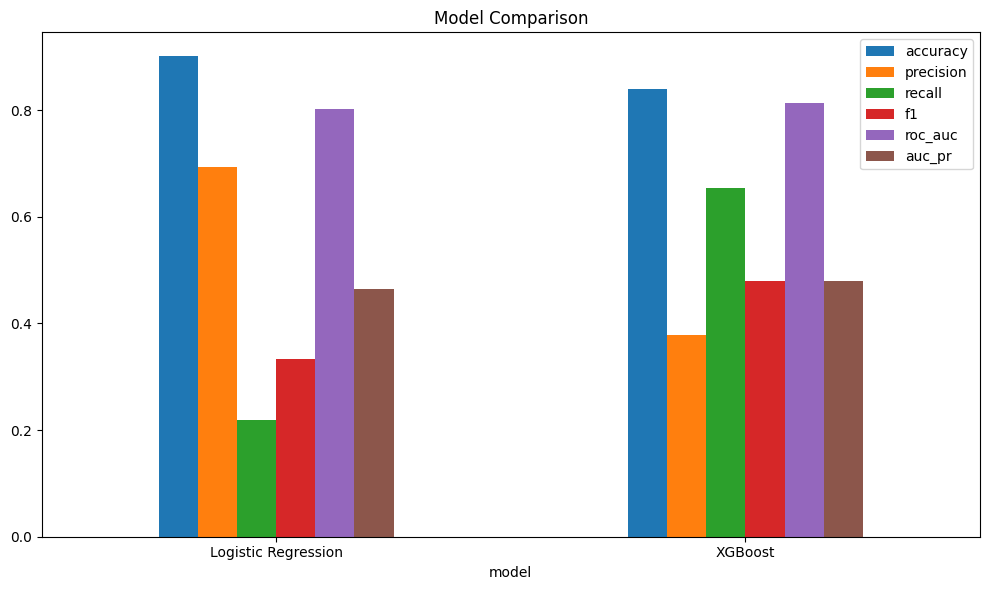

In [6]:
results = []
results.append(evaluate_model(logreg_model, X_test, y_test, name="Logistic Regression"))
results.append(evaluate_model(xgb_model, X_test, y_test, name="XGBoost"))

df_results = pd.DataFrame(results).set_index("model")
df_results.plot(kind="bar", figsize=(10, 6), title="Model Comparison")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## Evaluation Plots

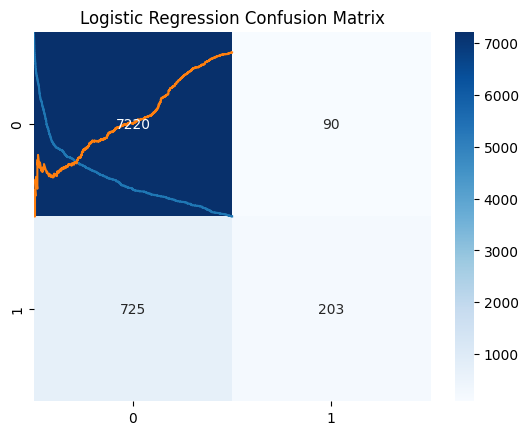

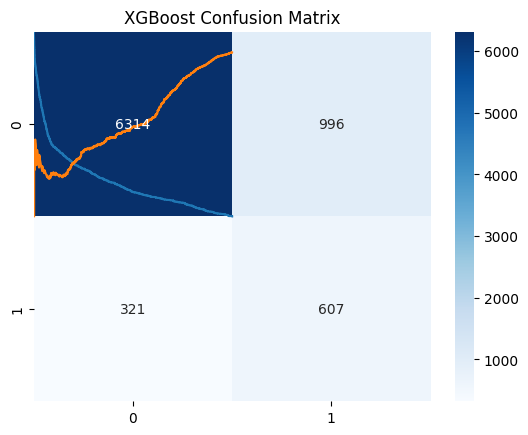

In [7]:
def plot_curves(model, X_test, y_test, name):
    y_prob = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)

    # ROC
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{name} ROC")
    
    # PR
    prec, rec, _ = precision_recall_curve(y_test, y_prob)
    plt.plot(rec, prec, label=f"{name} PR")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} Confusion Matrix")
    plt.show()

plot_curves(logreg_model, X_test, y_test, "Logistic Regression")
plot_curves(xgb_model, X_test, y_test, "XGBoost")


## SHAP Feature Importance

In [8]:
def get_pipeline_feature_names(pipeline):
    """
    Given a pipeline with a 'preprocessing' step, returns the list of transformed feature names.
    Works with OneHotEncoder and numeric passthrough/scaling.
    """
    preprocessor = pipeline.named_steps["preprocessing"].named_steps["preprocessor"]

    final_feature_names = []

    for name, transformer, cols in preprocessor.transformers_:
        if transformer == 'drop':
            continue
        if transformer == 'passthrough':
            final_feature_names.extend(cols)
        elif hasattr(transformer, 'get_feature_names_out'):
            try:
                names = transformer.get_feature_names_out(cols)
            except TypeError:
                names = transformer.get_feature_names_out()
            final_feature_names.extend(names)
        else:
            final_feature_names.extend(cols)  # fallback

    return final_feature_names

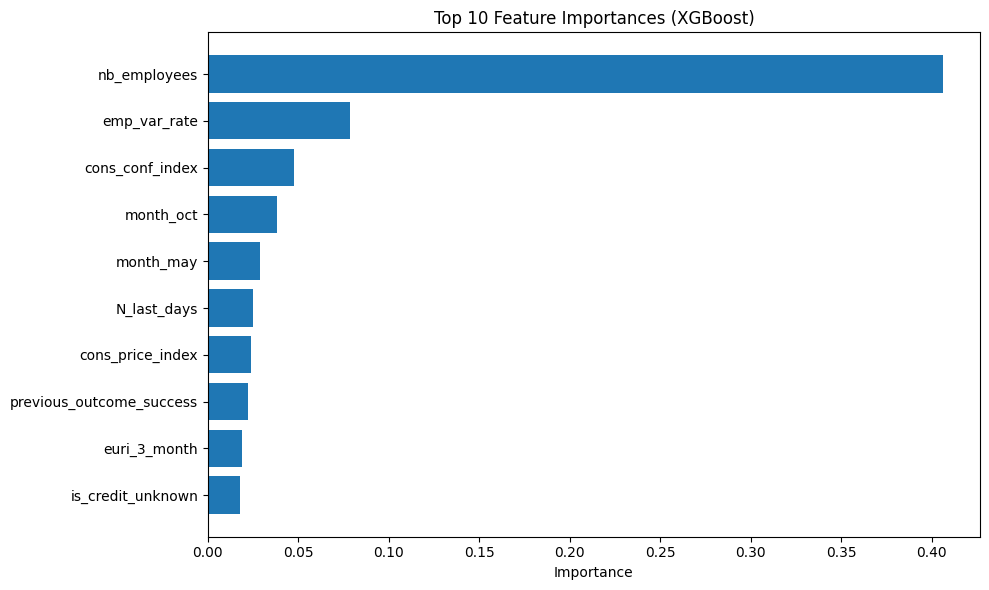

In [9]:
xgb = xgb_model.named_steps["classifier"]
feature_names = get_pipeline_feature_names(xgb_model)

# Plot with named y-axis labels
importances = xgb.feature_importances_
feat_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feat_df["feature"][:10][::-1], feat_df["importance"][:10][::-1])
plt.title("Top 10 Feature Importances (XGBoost)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

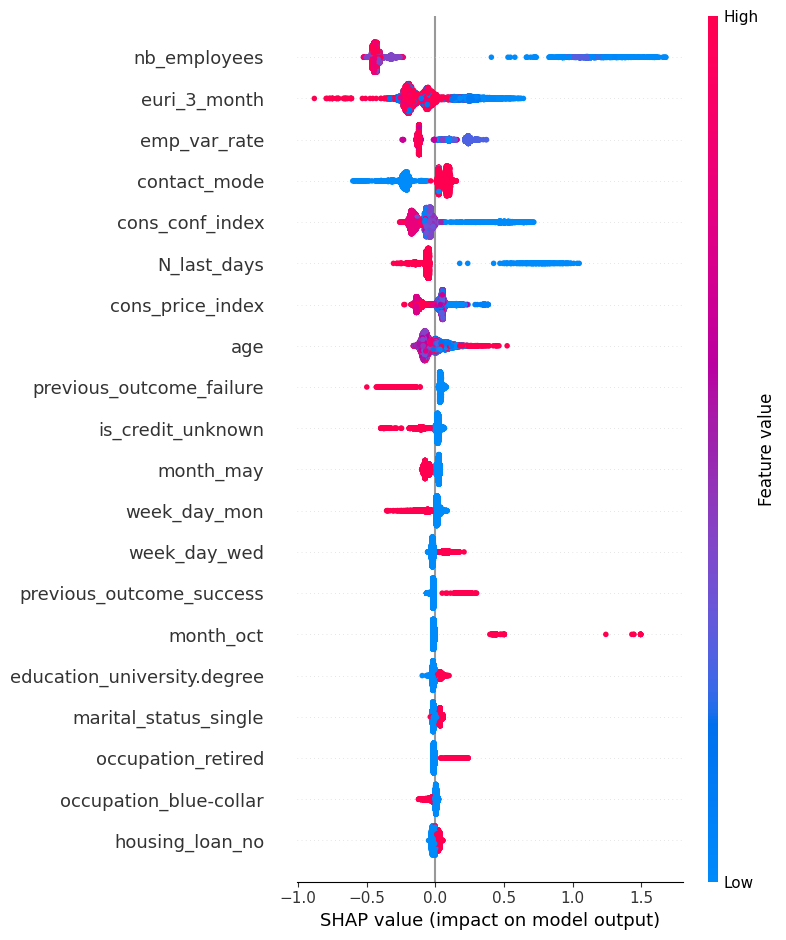

In [10]:
X_preprocessed = xgb_model.named_steps["preprocessing"].transform(X_test)

explainer = shap.Explainer(xgb)
shap_values = explainer(X_preprocessed)

shap.summary_plot(shap_values, features=X_preprocessed, feature_names=feature_names)

## Grouped feature importance

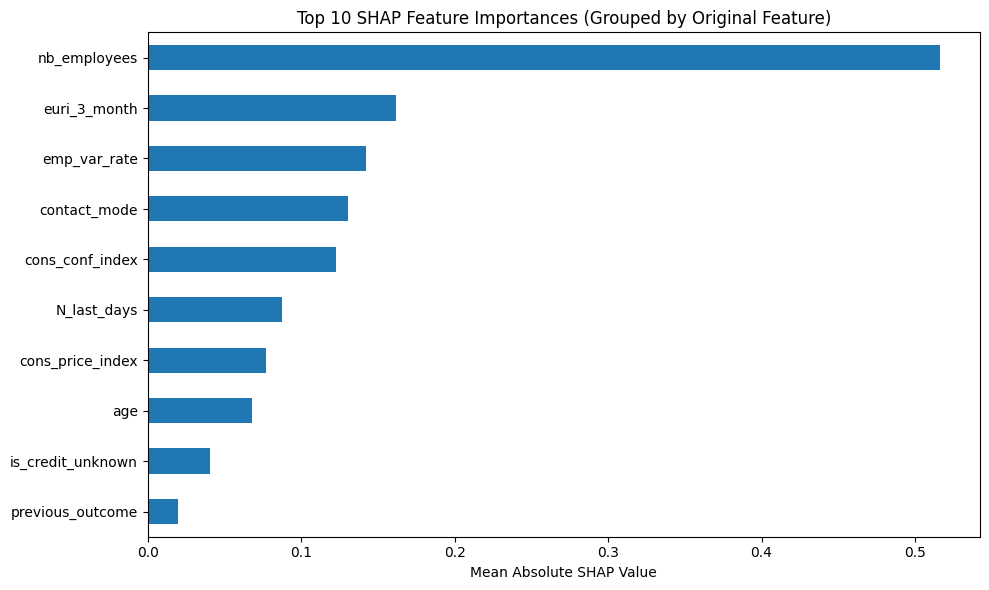

In [11]:
def get_transformed_to_original_feature_map(pipeline):
    """
    Maps transformed (e.g., one-hot encoded) feature names to their original feature name.
    """
    preprocessor = pipeline.named_steps["preprocessing"].named_steps["preprocessor"]
    mapping = []

    for name, transformer, cols in preprocessor.transformers_:
        if transformer == 'drop':
            continue
        if transformer == 'passthrough':
            mapping.extend([(col, col) for col in cols])
        elif hasattr(transformer, 'get_feature_names_out'):
            try:
                transformed_names = transformer.get_feature_names_out(cols)
            except TypeError:
                transformed_names = transformer.get_feature_names_out()
            mapping.extend([(transformed_name, orig_col) for transformed_name, orig_col in zip(transformed_names, np.repeat(cols, len(transformed_names)//len(cols)))])
        else:
            mapping.extend([(col, col) for col in cols])  # fallback

    return dict(mapping)

# Get mapping
transformed_to_original = get_transformed_to_original_feature_map(xgb_model)

# Create DataFrame of SHAP values
shap_df = pd.DataFrame(np.abs(shap_values.values), columns=feature_names)

# Map columns to original features
grouped_columns = defaultdict(list)
for col in shap_df.columns:
    original = transformed_to_original.get(col, col)
    grouped_columns[original].append(col)

# Aggregate SHAP values per original feature
grouped_shap_values = {}
for orig_feature, cols in grouped_columns.items():
    grouped_shap_values[orig_feature] = shap_df[cols].mean(axis=1).mean()

# Plotting
grouped_series = pd.Series(grouped_shap_values).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
grouped_series.head(10).plot(kind="barh")
plt.title("Top 10 SHAP Feature Importances (Grouped by Original Feature)")
plt.xlabel("Mean Absolute SHAP Value")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()